In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn plotly


'\nFrooti UMmmmmmmmmmmmmmmmmmmmmm\n'

In [5]:
import pandas as pd

In [6]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/healthcare_dataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from datetime import datetime

# Set random seed
np.random.seed(42)

def load_and_preprocess_data():
    # Load dataset
    df = pd.read_csv('/content/drive/MyDrive/healthcare_dataset.csv')

    # Clean column names
    df.columns = df.columns.str.replace(' ', '_').str.lower()

    # Calculate length of stay
    df['date_of_admission'] = pd.to_datetime(df['date_of_admission'])
    df['discharge_date'] = pd.to_datetime(df['discharge_date'])
    df['length_of_stay'] = (df['discharge_date'] - df['date_of_admission']).dt.days

    # Create synthetic is_denied column
    df['is_denied'] = 0
    df.loc[df['billing_amount'] < 100, 'is_denied'] = 1
    df.loc[df['test_results'].isin(['Abnormal', 'Inconclusive']), 'is_denied'] = \
        df.loc[df['test_results'].isin(['Abnormal', 'Inconclusive'])]['is_denied'].apply(
            lambda x: np.random.choice([0, 1], p=[0.3, 0.7])
        )
    random_denials = np.random.choice([0, 1], size=len(df), p=[0.85, 0.15])
    df['is_denied'] = df['is_denied'] | random_denials

    # Select features
    features = ['age', 'gender', 'blood_type', 'medical_condition', 'billing_amount',
                'insurance_provider', 'room_number', 'admission_type', 'medication',
                'test_results', 'length_of_stay']
    X = df[features].copy()
    y = df['is_denied']

    # Encode categorical variables
    le = LabelEncoder()
    categorical_cols = ['gender', 'blood_type', 'medical_condition', 'insurance_provider',
                       'admission_type', 'medication', 'test_results']
    for col in categorical_cols:
        X.loc[:, col] = le.fit_transform(X[col])

    # Scale numerical features
    scaler = StandardScaler()
    numerical_cols = ['age', 'billing_amount', 'room_number', 'length_of_stay']
    X.loc[:, numerical_cols] = scaler.fit_transform(X[numerical_cols])

    return X, y, df

# Run preprocessing
X, y, df = load_and_preprocess_data()
print("Data preprocessed successfully. Shape of X:", X.shape, "Shape of y:", y.shape)

Data preprocessed successfully. Shape of X: (55500, 11) Shape of y: (55500,)


<ipython-input-10-ae826cd68d95>:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.09882435  0.53363905  1.24784178 ... -0.6907085  -0.43563609
  0.07450872]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, numerical_cols] = scaler.fit_transform(X[numerical_cols])
<ipython-input-10-ae826cd68d95>:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.23311956 -0.31355599 -0.83419937 ...  0.39798996  0.17237783
  1.27440631]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, numerical_cols] = scaler.fit_transform(X[numerical_cols])
<ipython-input-10-ae826cd68d95>:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.56001783 -1.09809858 -0.05878027 ...  1.4424573  -1.09809858
 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    return model, metrics, X_test, y_test, y_pred

# Train model
model, metrics, X_test, y_test, y_pred = train_model(X, y)
print("Model Performance:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

Model Performance:
Accuracy: 0.7806
Precision: 0.7417
Recall: 0.9115
F1: 0.8179


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_static_visualizations(metrics, X_test, y_test, y_pred, df, model):
    # Plot metrics
    plt.figure(figsize=(10, 6))
    plt.bar(metrics.keys(), metrics.values(), color='skyblue')
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.savefig('/content/metrics_plot.png')
    plt.close()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('/content/confusion_matrix.png')
    plt.close()

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': np.abs(model.coef_[0])
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.savefig('/content/feature_importance.png')
    plt.close()

# Create static visualizations
create_static_visualizations(metrics, X_test, y_test, y_pred, df, model)
print("Static visualizations saved as PNGs in /content/")

Static visualizations saved as PNGs in /content/


In [13]:
import plotly.express as px
import plotly.graph_objects as go

def create_interactive_visualizations(df, metrics, model, X_test, y_test, y_pred):
    # Metrics bar plot
    fig_metrics = px.bar(
        x=list(metrics.keys()),
        y=list(metrics.values()),
        labels={'x': 'Metric', 'y': 'Score'},
        title='Model Performance Metrics'
    )
    fig_metrics.update_layout(yaxis_range=[0, 1])
    fig_metrics.write_html('/content/metrics_plot.html')

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig_cm = go.Figure(
        data=go.Heatmap(
            z=cm,
            x=['Paid', 'Denied'],
            y=['Paid', 'Denied'],
            colorscale='Blues',
            showscale=False,
            text=cm,
            texttemplate="%{text}",
            textfont={"size": 20}
        )
    )
    fig_cm.update_layout(title='Confusion Matrix')
    fig_cm.write_html('/content/confusion_matrix.html')

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': np.abs(model.coef_[0])
    }).sort_values('Importance', ascending=False)
    fig_fi = px.bar(
        x=feature_importance['Importance'],
        y=feature_importance['Feature'],
        orientation='h',
        labels={'x': 'Importance', 'y': 'Feature'},
        title='Feature Importance'
    )
    fig_fi.write_html('/content/feature_importance.html')

    # Denial rate by medical condition
    fig_denial = px.histogram(
        df,
        x='medical_condition',
        color='is_denied',
        barmode='group',
        labels={'is_denied': 'Claim Status'},
        title='Denial Rate by Medical Condition'
    )
    fig_denial.write_html('/content/denial_by_condition.html')

# Create interactive visualizations
create_interactive_visualizations(df, metrics, model, X_test, y_test, y_pred)
print("Interactive visualizations saved as HTMLs in /content/")

# Save processed dataset
df.to_csv('/content/processed_healthcare_data.csv', index=False)
print("Processed dataset saved as /content/processed_healthcare_data.csv")

Interactive visualizations saved as HTMLs in /content/
Processed dataset saved as /content/processed_healthcare_data.csv


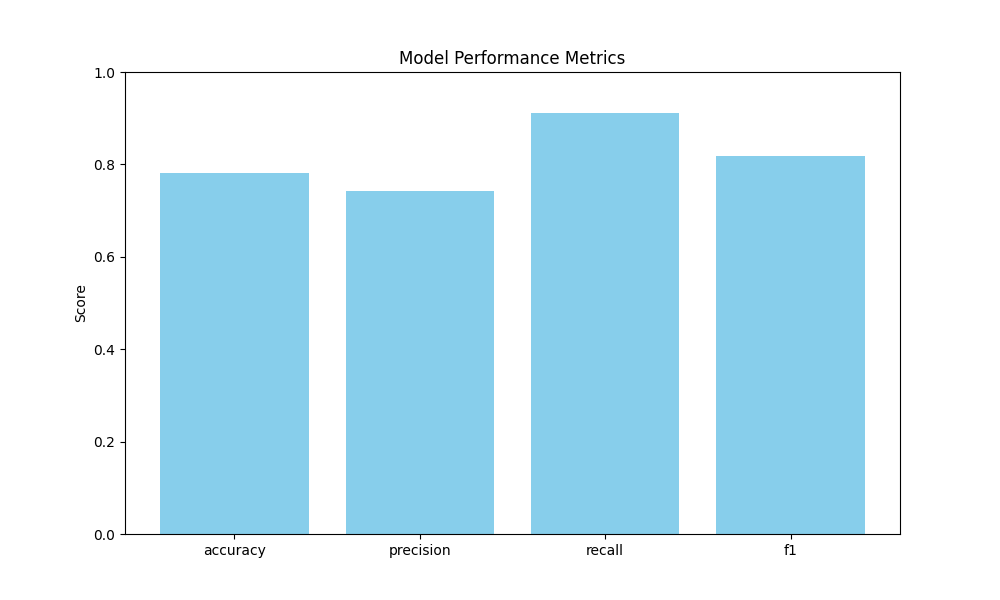

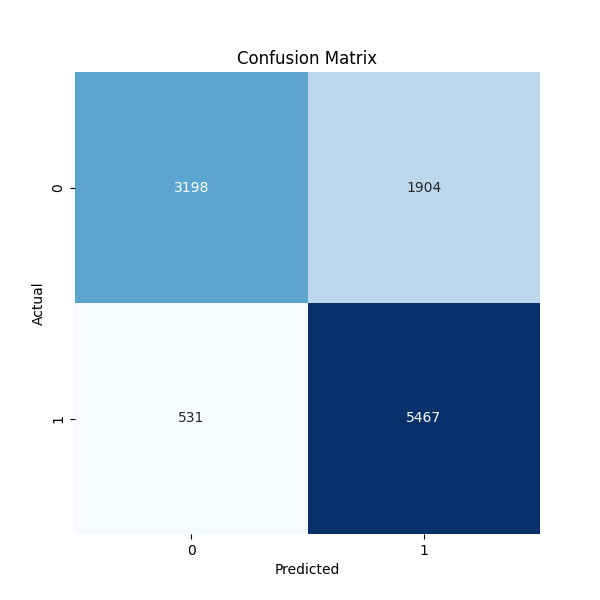

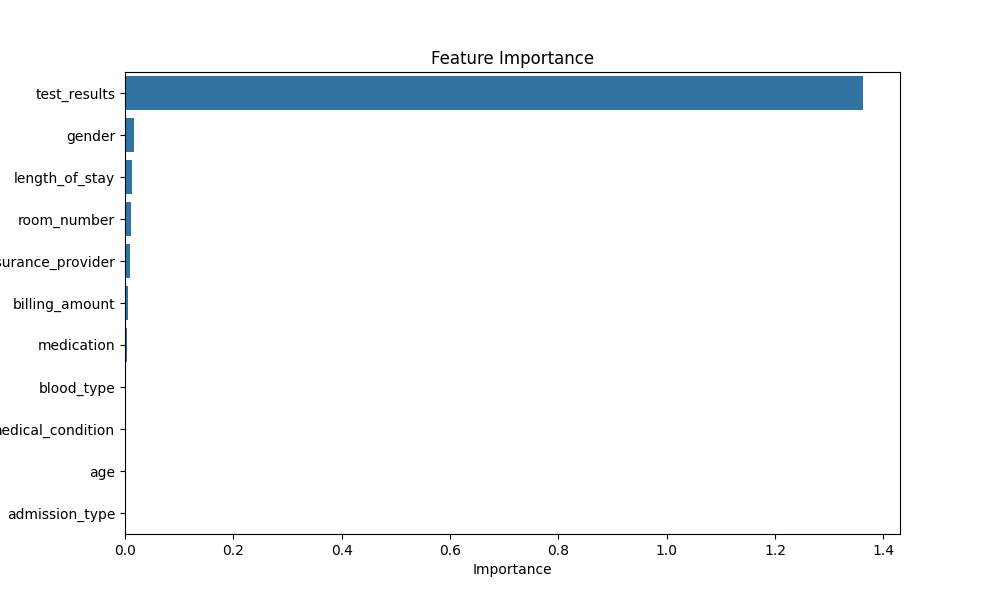

In [14]:
from IPython.display import Image, display
for img in ['metrics_plot.png', 'confusion_matrix.png', 'feature_importance.png']:
    display(Image(filename=f'/content/{img}'))